<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrame - parallelized pandas

Looks and feels like pandas, but **parallel and distributed** - `dask.dataframe`.

At its core, the  module implements a "blocked parallel" `DataFrame` object that looks and feels like the pandas API, but for parallel and distributed workflows. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrame`s separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.


<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg"
     align="right"
     width="30%"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

## When to use `dask.dataframe`

pandas is great for tabular datasets that fit in memory. A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Here "size of dataset" means dataset size on _the disk_.

Dask becomes useful when the datasets exceed the above rule.

## Create datasets

Download the dataset you will be using in this notebook:

In [ ]:
%run prep.py -d higgs

## Set up your local cluster

Create a local Dask cluster and connect it to the client. Don't worry about this bit of code for now, you will learn more in the Distributed notebook.

In [ ]:
import dask
from dask.distributed import Client

client = Client(n_workers=4)
client

/Users/nollde/tools/miniforge3/envs/dask-tutorial/lib/python3.14/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53295 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53295/status,
Dashboard: http://127.0.0.1:53295/status,Workers: 4
Total threads: 12,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53296,Workers: 0
Dashboard: http://127.0.0.1:53295/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53310,Total threads: 3
Dashboard: http://127.0.0.1:53316/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:53299,


2025-11-17 14:23:53,746 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:53310' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('read-fused-getitem-969d9289c28e1e2c8bcc4c2743846e09', 2)} (stimulus_id='handle-worker-cleanup-1763418233.746837')
2025-11-17 14:23:53,748 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:53309' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('read-fused-getitem-969d9289c28e1e2c8bcc4c2743846e09', 1)} (stimulus_id='handle-worker-cleanup-1763418233.748512')
2025-11-17 14:23:53,749 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:53308' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('read-fused-getitem-969d9289c28e1e2c8bcc4c2743846e09', 3)} (stimulus_id='handle-worker-cleanup-1763418233.749119')
2025-11-17 14:23:53,750 - distributed.scheduler - WARNING - Removing worker 'tcp:/

### Dask Diagnostic Dashboard

Dask Distributed provides a useful Dashboard to visualize the state of your cluster and computations.

If you're on **JupyterLab or Binder**, you can use the [Dask JupyterLab extension](https://github.com/dask/dask-labextension) (which should be already installed in your environment) to open the dashboard plots:
* Click on the Dask logo in the left sidebar
* Click on the magnifying glass icon, which will automatically connect to the active dashboard (if that doesn't work, you can type/paste the dashboard link http://127.0.0.1:8787 in the field)
* Click on **"Task Stream"**, **"Progress Bar"**, and **"Worker Memory"**, which will open these plots in new tabs
* Re-organize the tabs to suit your workflow!

Alternatively, click on the dashboard link displayed in the Client details above: http://127.0.0.1:8787/status. It will open a new browser tab with the Dashboard.

## Reading and working with datasets

Let's read in simulated pp collisions from the LHC and plot the Higgs peak in the invariant mass spectrum.

By convention, we import the module `dask.dataframe` as `dd`, and call the corresponding `DataFrame` object `ddf`.

**Note**: The term "Dask DataFrame" is slightly overloaded. Depending on the context, it can refer to the module or the DataFrame object. To avoid confusion, throughout this notebook:
- `dask.dataframe` (note the all lowercase) refers to the API, and
- `DataFrame` (note the CamelCase) refers to the object.

The following filename includes a glob pattern `*`, so all files in the path matching that pattern will be read into the same `DataFrame`.

In [2]:
import dask.dataframe as dd

higgs = dd.read_csv("data/higgs/higgs_*.csv")
higgs

,Index,diphoton_mass,diphoton_pt,diphoton_delta_R,photon1_pt,photon1_eta,photon1_phi,photon1_m,photon1_pt_rel,photon2_pt,photon2_eta,photon2_phi,photon2_m,photon2_pt_rel,dijet_mass,dijet_delta_R,HT_30,jet1_pt,jet1_eta,jet1_phi,jet1_m,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_m,jet2_btag,fatjet1_pt,fatjet1_eta,fatjet1_phi,fatjet1_m,fatjet1_btag,fatjet1_tau32,fatjet1_tau43,fatjet2_pt,fatjet2_eta,fatjet2_phi,fatjet2_m,fatjet2_btag,fatjet2_tau32,fatjet2_tau43,has_lepton,met_pt,n_photon,n_jet,n_fatjet,event_weight,event_number,selection_efficiency
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,int64,int64,int64,float64,int64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask has not loaded the data yet, it has:
- investigated the input path and found that there are ten matching files
- intelligently created a set of jobs for each chunk -- one per original CSV file in this case

Notice that the representation of the `DataFrame` object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

Some functions like `len` and `head` also trigger a computation. Specifically, calling `len` will:
- load actual data, (that is, load each file into a pandas DataFrame)
- then apply the corresponding functions to each pandas DataFrame (also known as a partition)
- combine the subtotals to give you the final grand total

In [3]:
# load and count number of rows
len(higgs)

400000

You can view the start and end of the data as you would in pandas:

In [4]:
higgs.head()

,Index,diphoton_mass,diphoton_pt,diphoton_delta_R,photon1_pt,photon1_eta,photon1_phi,photon1_m,photon1_pt_rel,photon2_pt,photon2_eta,photon2_phi,photon2_m,photon2_pt_rel,dijet_mass,dijet_delta_R,HT_30,jet1_pt,jet1_eta,jet1_phi,jet1_m,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_m,jet2_btag,fatjet1_pt,fatjet1_eta,fatjet1_phi,fatjet1_m,fatjet1_btag,fatjet1_tau32,fatjet1_tau43,fatjet2_pt,fatjet2_eta,fatjet2_phi,fatjet2_m,fatjet2_btag,fatjet2_tau32,fatjet2_tau43,has_lepton,met_pt,n_photon,n_jet,n_fatjet,event_weight,event_number,selection_efficiency
0,0,124636.695,58499.234,2.514340,81661.68,0.441137,0.251533,0.0,0.655198,45430.695,1.285224,2.619955,0.0,0.364505,NaN,NaN,47683.664,47683.664,-3.654594,-1.941081,5065.3770,0,NaN,NaN,NaN,NaN,4294967295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5603.0170,2,1,0,1.0,1,0.361733
1,1,124748.100,29935.973,2.798570,73689.68,-0.731911,2.944579,0.0,0.590708,53580.152,-0.475680,0.157763,0.0,0.429507,NaN,NaN,0.000,27333.549,3.206220,-0.339937,2985.2734,0,NaN,NaN,NaN,NaN,4294967295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,9339.8980,2,1,0,1.0,4,0.361733
2,2,124663.180,30265.596,3.280370,70917.88,1.477283,-2.296936,0.0,0.568876,40802.793,0.363623,0.788609,0.0,0.327304,NaN,NaN,0.000,NaN,NaN,NaN,NaN,4294967295,NaN,NaN,NaN,NaN,4294967295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,21362.5040,2,0,0,1.0,9,0.361733
3,3,126784.640,60036.652,2.798390,95364.97,1.924616,1.780142,0.0,0.752181,40586.953,2.473540,-0.963882,0.0,0.320125,NaN,NaN,79001.900,79001.900,-1.475222,-1.440586,7986.7993,0,NaN,NaN,NaN,NaN,4294967295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,7664.1133,2,1,0,1.0,11,0.361733
4,4,123592.720,57923.992,2.583883,84910.92,0.955675,-2.924045,0.0,0.687022,43017.800,0.187327,0.892140,0.0,0.348061,NaN,NaN,43386.137,43386.137,-2.447620,0.028447,8427.1900,0,NaN,NaN,NaN,NaN,4294967295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,16380.0110,2,1,0,1.0,16,0.361733


## Computations with `dask.dataframe`

Let's compute the maximum `photon1_pt` in the dataset.

With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums.

In [5]:
import os
import pandas as pd

maxes = []

for file in os.listdir("data/higgs"):
    df = pd.read_csv(f"data/higgs/{file}")
    maxes.append(df.diphoton_pt.max())
    
print(max(maxes))

1291652.5


`dask.dataframe` lets us write pandas-like code, that operates on larger-than-memory datasets in parallel.

In [6]:
higgs.diphoton_pt.max().compute()

np.float64(1291652.5)

Lets do something even more exciting and plot the spectrum of the invariant di-photon mass for all events which have a leading photon with a transverse momentum greater than 80 GeV.

In [7]:
pt_cut = higgs["photon1_pt"] > 80e3
selected_myy = higgs["diphoton_mass"][pt_cut]

### Lazy Evaluation

Most Dask Collections, including Dask `DataFrame` are evaluated lazily, which means Dask constructs the logic (called task graph) of your computation immediately but "evaluates" them  only when necessary. You can view this task graph using `.visualize()`.

You will learn more about this in the Delayed notebook, but for now, note that we need to call `.compute()` to trigger actual computations.

So the code executed immediately because the only thing that happended is, that the computational graph was constructed. Let's first have a look at the graph

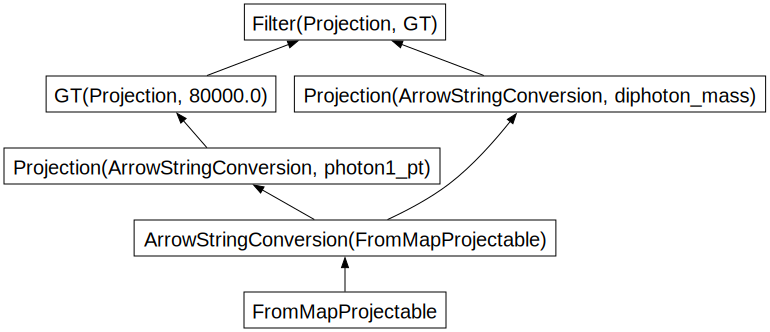

In [8]:
selected_myy.visualize()

Now, let's perform the computation

In [9]:
%time
selected_myy_materialized = selected_myy.compute()

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 7.87 μs


and plot the invariant mass spectrum

Text(0, 0.5, 'Counts')

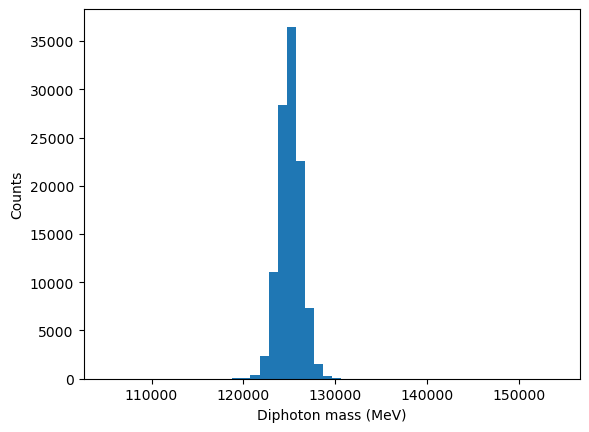

In [10]:
from matplotlib import pyplot as plt

_ = plt.hist(selected_myy_materialized, bins=50)
plt.xlabel("Diphoton mass (MeV)")
plt.ylabel("Counts")

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` stores the arguments, allowing duplicate computations to be shared and only computed once.

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results yet. They're just the steps required to get the result.

If you compute them with two calls to compute, there is no sharing of intermediate computations.

In [11]:
pt_cut = higgs["photon1_pt"] > 80e3
selected_myy = higgs["diphoton_mass"][pt_cut]
mean_myy = selected_myy.mean()
std_myy = selected_myy.std()

In [12]:
%%time

mean_myy_res = mean_myy.compute()
std_myy_res = std_myy.compute()

CPU times: user 50.9 ms, sys: 13.2 ms, total: 64.2 ms
Wall time: 431 ms


### `dask.compute`

But let's try by passing both to a single `compute` call.

In [13]:
%%time

mean_myy_res, std_myy_res = dask.compute(mean_myy, std_myy)

CPU times: user 29.1 ms, sys: 7.99 ms, total: 37.1 ms
Wall time: 238 ms


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`[pt_cut]`)
- some of the necessary reductions (`sum`, `count`)

### `.persist()`

While using a distributed scheduler (you will learn more about schedulers in the upcoming notebooks), you can keep some _data that you want to use often_ in the _distributed memory_. 

`persist` generates "Futures" (more on this later as well) and stores them in the same structure as your output. You can use `persist` with any data or computation that fits in memory.

In [14]:
selected_myy = selected_myy.persist()  # returns back control immediately

## Close your local Dask Cluster

It's good practice to always close any Dask cluster you create:

In [15]:
client.shutdown()